In [59]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,  Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import yfinance as yf
from pandas_datareader.data import DataReader


In [60]:
def plot(prediction,target,grey=None,start=None,end=None):
    # if start is None:
    #     start=df.index.min()
    # if end is None:
    #     end=df.index.max()
    # recessions=DataReader('USREC', 'fred', start=start,end=end)['USREC']

    # pd.concat([,target],axis=1,ignore_index=False).plot()
    fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
    
    # if isinstance(df,pd.DataFrame):
    # else:
    #     ylim = (df.min(),df.max())
        

    Results=pd.DataFrame(prediction,index=target.index)
    Results.plot(ax=ax,legend=True)
    Results['target']=target
    ylim = (Results.min().min(),Results.max().max())
    ax.fill_between(Results['target'].index, 0, ylim[1]+1e-2, Results['target'],facecolor='k', alpha=0.1)
    ax.legend(["Prediction", "NBER recession indicator"])
    return fig,ax

In [61]:
# df=yf.download("GE")
# df.head()
n_lookback=30
n_forecast=1

df=pd.read_csv('Data/Transformed HistoricalVariables.csv',index_col=0,parse_dates=True)
recessions =  DataReader('USRECDM', 'fred', start='1800')
df[f'in a recession']=recessions
df['target'] = recessions.shift(-250)

df.fillna(method='ffill',inplace=True)
# df=df.fillna(-1)
df=df['1971':] #.resample('MS').last()
print(df.shape)
df.head()

(11070, 126)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio,in a recession,target
1971-01-01,0.008594,0.0096,0.013628,0.00975,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,0.0,0.007963,-0.003878,-0.00768,0.023135,NaN,0.0,0.031962,0,0.0
1971-01-02,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,-0.007963,0.003878,0.00768,-0.023135,NaN,0.0,0.000000,0,0.0
1971-01-09,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0,0.0
1971-01-16,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0,0.0
1971-01-23,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0,0.0


<Axes: >

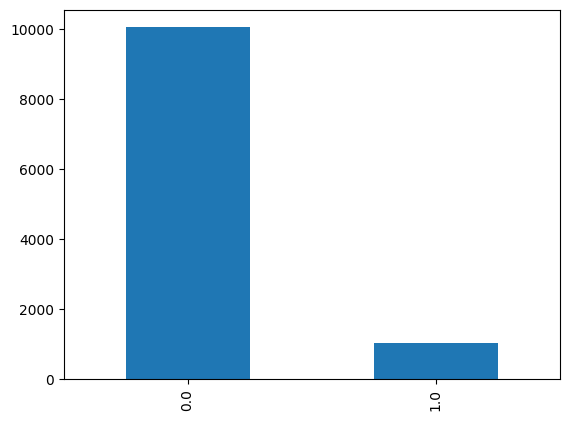

In [62]:
df.target.value_counts().plot.bar()

In [63]:
df.columns

Index(['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPL', 'RSXFS', 'INDPRO',
       'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD',
       ...
       'UMCSENT', 'MZMSL', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'S&P: indust',
       'S&P div yield', 'S&P PE ratio', 'in a recession', 'target'],
      dtype='object', length=126)

<Axes: >

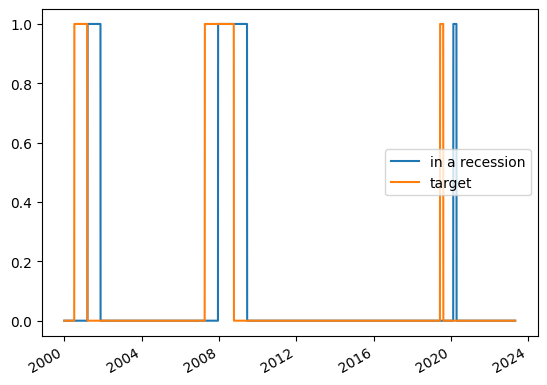

In [64]:
df.loc["2000":,['in a recession', 'target']].plot()

In [65]:
test_split=round(len(df)*0.20)
df_for_training=df[:"2004"]
df_for_testing=df["2004":]
print('df_for_training shape: ',df_for_training.shape)
print('df_for_testing shape: ',df_for_testing.shape)

df_for_training shape:  (5292, 126)
df_for_testing shape:  (6096, 126)


In [66]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
# df_for_training_scaled[np.isnan(df_for_training_scaled)] = -1
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))
# df_for_testing_scaled[np.isnan(df_for_testing_scaled)] = -1


In [67]:
def createXY(dataset,n_lookback = 60,n_forecast = 3,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:dataset.shape[1]-1])
        Y.append(dataset[i: i + n_forecast,target_col])

    return np.array(X),np.array(Y)



In [68]:
trainX,trainY=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX,testY=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)

# with recessions 

In [69]:
trainX.shape[1]

30

In [76]:
from tensorflow.keras.layers import LSTM,  Dense, Dropout, Conv1D, MaxPool1D,Flatten,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


f1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
f2 = ModelCheckpoint(filepath='Model/CNN2-LSTM', monitor='recall', mode='max', verbose=1, save_best_only=True)


model = Sequential()
model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]),))
model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu'))
# model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu'))
model.add(MaxPool1D(1))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(RepeatVector(1))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(n_forecast))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 28, 32)            12032     
                                                                 
 conv1d_13 (Conv1D)          (None, 26, 32)            3104      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 26, 32)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 26, 32)            0         
                                                                 
 flatten_6 (Flatten)         (None, 832)               0         
                                                                 
 repeat_vector_6 (RepeatVect  (None, 1, 832)           0         
 or)                                                  

In [77]:
# fit the model
model.compile(optimizer='adam',
              metrics=["mse", 'accuracy','Recall',"AUC"],
              loss=lambda labels, logits: tf.nn.weighted_cross_entropy_with_logits(labels, logits, 0.2)
              # loss='BinaryCrossentropy'
              )
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=320, 
                    validation_split=0.1, 
                    verbose=1,  
                    callbacks=[
                                # f1,
                                f2
                               ]
                  )


Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.1782 - mse: 18.6176 - accuracy: 0.8959 - recall: 0.0000e+00 - auc: 0.5003
Epoch 1: recall improved from -inf to 0.00000, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 25s 1s/step - loss: 0.1782 - mse: 18.6176 - accuracy: 0.8959 - recall: 0.0000e+00 - auc: 0.5003 - val_loss: 0.0145 - val_mse: 17.8646 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.0993 - mse: 14.3749 - accuracy: 0.8959 - recall: 0.0000e+00 - auc: 0.5000
Epoch 2: recall did not improve from 0.00000
15/15 [==============================] - 1s 53ms/step - loss: 0.0993 - mse: 14.3749 - accuracy: 0.8959 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 0.0202 - val_mse: 15.1506 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0987 - mse: 15.0067 - accuracy: 0.8958 - recall: 0.0000e+00 - auc: 0.5000
Epoch 3: recall did not improve from 0.00000
15/15 [==============================] - 1s 51ms/step - loss: 0.0986 - mse: 14.9260 - accuracy: 0.8959 - recall: 0.0000e+00 - auc

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 12s 839ms/step - loss: 0.0467 - mse: 51.8742 - accuracy: 0.8965 - recall: 0.0061 - auc: 0.5375 - val_loss: 1.4032e-04 - val_mse: 79.3040 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 38/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0445 - mse: 52.1818 - accuracy: 0.8982 - recall: 0.0151 - auc: 0.5421
Epoch 38: recall improved from 0.00609 to 0.02028, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 12s 837ms/step - loss: 0.0446 - mse: 52.0269 - accuracy: 0.8980 - recall: 0.0203 - auc: 0.5467 - val_loss: 1.0598e-04 - val_mse: 84.1553 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 39/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0468 - mse: 55.9971 - accuracy: 0.9011 - recall: 0.0349 - auc: 0.5566
Epoch 39: recall improved from 0.02028 to 0.03245, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 13s 953ms/step - loss: 0.0477 - mse: 55.2525 - accuracy: 0.8993 - recall: 0.0325 - auc: 0.5538 - val_loss: 1.3392e-04 - val_mse: 80.9602 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 40/100
15/15 [==============================] - ETA: 0s - loss: 0.0467 - mse: 54.8273 - accuracy: 0.8995 - recall: 0.0345 - auc: 0.5517
Epoch 40: recall improved from 0.03245 to 0.03448, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 12s 842ms/step - loss: 0.0467 - mse: 54.8273 - accuracy: 0.8995 - recall: 0.0345 - auc: 0.5517 - val_loss: 8.0831e-05 - val_mse: 89.1368 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 41/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0421 - mse: 57.0105 - accuracy: 0.9002 - recall: 0.0408 - auc: 0.5740
Epoch 41: recall improved from 0.03448 to 0.04260, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 13s 946ms/step - loss: 0.0422 - mse: 56.8843 - accuracy: 0.9003 - recall: 0.0426 - auc: 0.5730 - val_loss: 8.3011e-05 - val_mse: 89.0262 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 42/100
15/15 [==============================] - ETA: 0s - loss: 0.0415 - mse: 59.6196 - accuracy: 0.9020 - recall: 0.0588 - auc: 0.5761
Epoch 42: recall improved from 0.04260 to 0.05882, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 12s 829ms/step - loss: 0.0415 - mse: 59.6196 - accuracy: 0.9020 - recall: 0.0588 - auc: 0.5761 - val_loss: 7.2537e-05 - val_mse: 91.7557 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 43/100
15/15 [==============================] - ETA: 0s - loss: 0.0476 - mse: 60.3028 - accuracy: 0.9041 - recall: 0.0791 - auc: 0.5867
Epoch 43: recall improved from 0.05882 to 0.07911, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 14s 979ms/step - loss: 0.0476 - mse: 60.3028 - accuracy: 0.9041 - recall: 0.0791 - auc: 0.5867 - val_loss: 6.6931e-05 - val_mse: 93.4438 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 44/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0419 - mse: 61.6541 - accuracy: 0.9089 - recall: 0.1169 - auc: 0.5950
Epoch 44: recall improved from 0.07911 to 0.12373, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 12s 862ms/step - loss: 0.0422 - mse: 62.0022 - accuracy: 0.9088 - recall: 0.1237 - auc: 0.5982 - val_loss: 4.4826e-05 - val_mse: 100.5562 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 45/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0379 - mse: 63.7542 - accuracy: 0.9080 - recall: 0.1178 - auc: 0.5953
Epoch 45: recall did not improve from 0.12373
15/15 [==============================] - 1s 58ms/step - loss: 0.0381 - mse: 63.8071 - accuracy: 0.9083 - recall: 0.1197 - auc: 0.5943 - val_loss: 4.0387e-05 - val_mse: 102.7952 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 46/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0372 - mse: 66.4746 - accuracy: 0.9100 - recall: 0.1143 - auc: 0.6219
Epoch 46: recall did not improve from 0.12373
15/15 [==============================] - 1s 56ms/step - loss: 0.0384 - mse: 66.7306 - accuracy: 0.9075 - recall: 0.1116 - auc: 0

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 12s 879ms/step - loss: 0.0479 - mse: 68.3876 - accuracy: 0.9107 - recall: 0.1420 - auc: 0.6350 - val_loss: 3.8409e-05 - val_mse: 104.1802 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 48/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0442 - mse: 62.4144 - accuracy: 0.9129 - recall: 0.1667 - auc: 0.6185
Epoch 48: recall improved from 0.14199 to 0.17039, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 12s 869ms/step - loss: 0.0441 - mse: 62.2230 - accuracy: 0.9136 - recall: 0.1704 - auc: 0.6205 - val_loss: 3.8804e-05 - val_mse: 103.9409 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 49/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0374 - mse: 67.1150 - accuracy: 0.9112 - recall: 0.1478 - auc: 0.6081
Epoch 49: recall did not improve from 0.17039
15/15 [==============================] - 1s 56ms/step - loss: 0.0372 - mse: 67.4789 - accuracy: 0.9111 - recall: 0.1460 - auc: 0.6095 - val_loss: 2.9683e-05 - val_mse: 109.1820 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 50/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0370 - mse: 69.2803 - accuracy: 0.9167 - recall: 0.2047 - auc: 0.6713
Epoch 50: recall improved from 0.17039 to 0.20081, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 13s 894ms/step - loss: 0.0362 - mse: 69.6686 - accuracy: 0.9168 - recall: 0.2008 - auc: 0.6690 - val_loss: 2.6634e-05 - val_mse: 111.4813 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 51/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0334 - mse: 72.7080 - accuracy: 0.9158 - recall: 0.1910 - auc: 0.6798
Epoch 51: recall did not improve from 0.20081
15/15 [==============================] - 1s 57ms/step - loss: 0.0338 - mse: 72.7027 - accuracy: 0.9153 - recall: 0.1866 - auc: 0.6730 - val_loss: 2.1674e-05 - val_mse: 115.9509 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 52/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0335 - mse: 75.8265 - accuracy: 0.9223 - recall: 0.2484 - auc: 0.7110
Epoch 52: recall improved from 0.20081 to 0.24746, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 13s 913ms/step - loss: 0.0332 - mse: 75.6167 - accuracy: 0.9216 - recall: 0.2475 - auc: 0.7154 - val_loss: 2.3440e-05 - val_mse: 114.8764 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 53/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0331 - mse: 76.6541 - accuracy: 0.9187 - recall: 0.2239 - auc: 0.6967
Epoch 53: recall did not improve from 0.24746
15/15 [==============================] - 1s 62ms/step - loss: 0.0333 - mse: 76.6445 - accuracy: 0.9208 - recall: 0.2394 - auc: 0.7021 - val_loss: 1.6719e-05 - val_mse: 121.7548 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 54/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0364 - mse: 79.1607 - accuracy: 0.9326 - recall: 0.3499 - auc: 0.7465
Epoch 54: recall improved from 0.24746 to 0.34280, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 11s 787ms/step - loss: 0.0361 - mse: 79.3166 - accuracy: 0.9314 - recall: 0.3428 - auc: 0.7406 - val_loss: 1.1413e-05 - val_mse: 129.8847 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 55/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0439 - mse: 78.3326 - accuracy: 0.9268 - recall: 0.3156 - auc: 0.7028
Epoch 55: recall did not improve from 0.34280
15/15 [==============================] - 1s 63ms/step - loss: 0.0434 - mse: 78.3410 - accuracy: 0.9271 - recall: 0.3144 - auc: 0.7001 - val_loss: 1.2883e-05 - val_mse: 127.1751 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 56/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0341 - mse: 78.8210 - accuracy: 0.9179 - recall: 0.2069 - auc: 0.6678
Epoch 56: recall did not improve from 0.34280
15/15 [==============================] - 1s 62ms/step - loss: 0.0353 - mse: 78.1336 - accuracy: 0.9176 - recall: 0.2130 - auc: 0

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 12s 883ms/step - loss: 0.0298 - mse: 84.9219 - accuracy: 0.9324 - recall: 0.3550 - auc: 0.7643 - val_loss: 9.7231e-06 - val_mse: 133.6329 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 60/100
15/15 [==============================] - ETA: 0s - loss: 0.0273 - mse: 87.4026 - accuracy: 0.9362 - recall: 0.3895 - auc: 0.7774
Epoch 60: recall improved from 0.35497 to 0.38945, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 12s 822ms/step - loss: 0.0273 - mse: 87.4026 - accuracy: 0.9362 - recall: 0.3895 - auc: 0.7774 - val_loss: 1.0807e-05 - val_mse: 131.5295 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 61/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0270 - mse: 88.4986 - accuracy: 0.9440 - recall: 0.4722 - auc: 0.8081
Epoch 61: recall improved from 0.38945 to 0.48682, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 12s 817ms/step - loss: 0.0277 - mse: 87.9221 - accuracy: 0.9451 - recall: 0.4868 - auc: 0.8154 - val_loss: 9.1079e-06 - val_mse: 135.0464 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 62/100
15/15 [==============================] - ETA: 0s - loss: 0.0285 - mse: 89.3133 - accuracy: 0.9362 - recall: 0.3895 - auc: 0.7855
Epoch 62: recall did not improve from 0.48682
15/15 [==============================] - 1s 59ms/step - loss: 0.0285 - mse: 89.3133 - accuracy: 0.9362 - recall: 0.3895 - auc: 0.7855 - val_loss: 8.0185e-06 - val_mse: 138.3617 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 63/100
15/15 [==============================] - ETA: 0s - loss: 0.0288 - mse: 92.6437 - accuracy: 0.9457 - recall: 0.4848 - auc: 0.8095
Epoch 63: recall did not improve from 0.48682
15/15 [==============================] - 1s 49ms/step - loss: 0.0288 - mse: 92.6437 - accuracy: 0.9457 - recall: 0.4848 - auc: 0

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 9s 633ms/step - loss: 0.0225 - mse: 95.2755 - accuracy: 0.9565 - recall: 0.5943 - auc: 0.8441 - val_loss: 7.9841e-06 - val_mse: 138.5558 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 66/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0222 - mse: 98.4166 - accuracy: 0.9609 - recall: 0.6336 - auc: 0.8675
Epoch 66: recall improved from 0.59432 to 0.62880, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 10s 717ms/step - loss: 0.0223 - mse: 98.5694 - accuracy: 0.9603 - recall: 0.6288 - auc: 0.8631 - val_loss: 4.3485e-06 - val_mse: 153.3499 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 67/100
15/15 [==============================] - ETA: 0s - loss: 0.0262 - mse: 100.0573 - accuracy: 0.9550 - recall: 0.5882 - auc: 0.8322
Epoch 67: recall did not improve from 0.62880
15/15 [==============================] - 1s 54ms/step - loss: 0.0262 - mse: 100.0573 - accuracy: 0.9550 - recall: 0.5882 - auc: 0.8322 - val_loss: 3.6193e-06 - val_mse: 156.9270 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 68/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0269 - mse: 98.1741 - accuracy: 0.9545 - recall: 0.5754 - auc: 0.8316
Epoch 68: recall did not improve from 0.62880
15/15 [==============================] - 1s 54ms/step - loss: 0.0261 - mse: 98.5359 - accuracy: 0.9548 - recall: 0.5740 - auc:

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 7s 522ms/step - loss: 0.0212 - mse: 110.2870 - accuracy: 0.9622 - recall: 0.6531 - auc: 0.8660 - val_loss: 2.2439e-06 - val_mse: 168.9542 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 77/100
15/15 [==============================] - ETA: 0s - loss: 0.0192 - mse: 112.2367 - accuracy: 0.9620 - recall: 0.6491 - auc: 0.8733
Epoch 77: recall did not improve from 0.65314
15/15 [==============================] - 1s 48ms/step - loss: 0.0192 - mse: 112.2367 - accuracy: 0.9620 - recall: 0.6491 - auc: 0.8733 - val_loss: 2.3634e-06 - val_mse: 167.1373 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 78/100
15/15 [==============================] - ETA: 0s - loss: 0.0179 - mse: 113.2964 - accuracy: 0.9658 - recall: 0.6775 - auc: 0.8769
Epoch 78: recall improved from 0.65314 to 0.67748, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 8s 553ms/step - loss: 0.0179 - mse: 113.2964 - accuracy: 0.9658 - recall: 0.6775 - auc: 0.8769 - val_loss: 2.2928e-06 - val_mse: 169.7619 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 79/100
15/15 [==============================] - ETA: 0s - loss: 0.0209 - mse: 115.1009 - accuracy: 0.9675 - recall: 0.7039 - auc: 0.8753
Epoch 79: recall improved from 0.67748 to 0.70385, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 7s 504ms/step - loss: 0.0209 - mse: 115.1009 - accuracy: 0.9675 - recall: 0.7039 - auc: 0.8753 - val_loss: 2.0087e-06 - val_mse: 174.6474 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 80/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0180 - mse: 116.2290 - accuracy: 0.9688 - recall: 0.7073 - auc: 0.8862
Epoch 80: recall improved from 0.70385 to 0.71197, saving model to Model\CNN2-LSTM


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 7s 499ms/step - loss: 0.0174 - mse: 116.6834 - accuracy: 0.9694 - recall: 0.7120 - auc: 0.8890 - val_loss: 2.0865e-06 - val_mse: 173.5683 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 81/100
14/15 [===========================>..] - ETA: 0s - loss: 0.0164 - mse: 120.3544 - accuracy: 0.9696 - recall: 0.7072 - auc: 0.8869
Epoch 81: recall did not improve from 0.71197
15/15 [==============================] - 1s 53ms/step - loss: 0.0196 - mse: 121.5124 - accuracy: 0.9664 - recall: 0.6795 - auc: 0.8709 - val_loss: 1.9417e-06 - val_mse: 174.7106 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 82/100
15/15 [==============================] - ETA: 0s - loss: 0.0300 - mse: 109.0133 - accuracy: 0.9597 - recall: 0.6329 - auc: 0.8416
Epoch 82: recall did not improve from 0.71197
15/15 [==============================] - 1s 55ms/step - loss: 0.0300 - mse: 109.0133 - accuracy: 0.9597 - recall: 0.6329 - au

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 7s 490ms/step - loss: 0.0143 - mse: 112.1520 - accuracy: 0.9734 - recall: 0.7505 - auc: 0.9112 - val_loss: 1.9236e-06 - val_mse: 175.3841 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 86/100
15/15 [==============================] - ETA: 0s - loss: 0.0217 - mse: 116.8764 - accuracy: 0.9614 - recall: 0.6471 - auc: 0.8561
Epoch 86: recall did not improve from 0.75051
15/15 [==============================] - 1s 49ms/step - loss: 0.0217 - mse: 116.8764 - accuracy: 0.9614 - recall: 0.6471 - auc: 0.8561 - val_loss: 2.9678e-06 - val_mse: 164.8452 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 87/100
15/15 [==============================] - ETA: 0s - loss: 0.0187 - mse: 117.9412 - accuracy: 0.9668 - recall: 0.6897 - auc: 0.8768
Epoch 87: recall did not improve from 0.75051
15/15 [==============================] - 1s 47ms/step - loss: 0.0187 - mse: 117.9412 - accuracy: 0.9668 - recall: 0.6897 - au

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 6s 459ms/step - loss: 0.0121 - mse: 126.5830 - accuracy: 0.9766 - recall: 0.7769 - auc: 0.9248 - val_loss: 1.0224e-06 - val_mse: 191.9786 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 91/100
15/15 [==============================] - ETA: 0s - loss: 0.0167 - mse: 135.0818 - accuracy: 0.9723 - recall: 0.7465 - auc: 0.9027
Epoch 91: recall did not improve from 0.77688
15/15 [==============================] - 1s 47ms/step - loss: 0.0167 - mse: 135.0818 - accuracy: 0.9723 - recall: 0.7465 - auc: 0.9027 - val_loss: 1.1509e-06 - val_mse: 191.8223 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 92/100
15/15 [==============================] - ETA: 0s - loss: 0.0189 - mse: 126.7669 - accuracy: 0.9679 - recall: 0.7120 - auc: 0.8945
Epoch 92: recall did not improve from 0.77688
15/15 [==============================] - 1s 56ms/step - loss: 0.0189 - mse: 126.7669 - accuracy: 0.9679 - recall: 0.7120 - au

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 7s 477ms/step - loss: 0.0119 - mse: 131.6096 - accuracy: 0.9791 - recall: 0.8114 - auc: 0.9377 - val_loss: 8.4329e-07 - val_mse: 205.6707 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 95/100
15/15 [==============================] - ETA: 0s - loss: 0.0194 - mse: 129.8223 - accuracy: 0.9658 - recall: 0.6836 - auc: 0.8777
Epoch 95: recall did not improve from 0.81136
15/15 [==============================] - 1s 47ms/step - loss: 0.0194 - mse: 129.8223 - accuracy: 0.9658 - recall: 0.6836 - auc: 0.8777 - val_loss: 1.1527e-06 - val_mse: 191.2052 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 96/100
15/15 [==============================] - ETA: 0s - loss: 0.0131 - mse: 129.3095 - accuracy: 0.9791 - recall: 0.8073 - auc: 0.9294
Epoch 96: recall did not improve from 0.81136
15/15 [==============================] - 1s 47ms/step - loss: 0.0131 - mse: 129.3095 - accuracy: 0.9791 - recall: 0.8073 - au

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


15/15 [==============================] - 6s 437ms/step - loss: 0.0121 - mse: 143.5281 - accuracy: 0.9818 - recall: 0.8377 - auc: 0.9383 - val_loss: 1.6287e-07 - val_mse: 222.7968 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 100/100
15/15 [==============================] - ETA: 0s - loss: 0.0263 - mse: 147.5576 - accuracy: 0.9563 - recall: 0.6004 - auc: 0.8306
Epoch 100: recall did not improve from 0.83773
15/15 [==============================] - 1s 46ms/step - loss: 0.0263 - mse: 147.5576 - accuracy: 0.9563 - recall: 0.6004 - auc: 0.8306 - val_loss: 1.7553e-07 - val_mse: 226.0394 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00


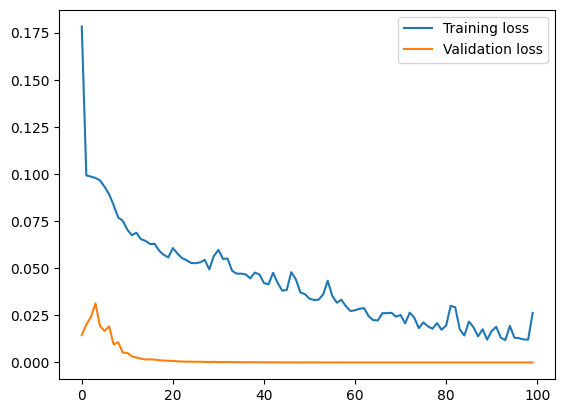

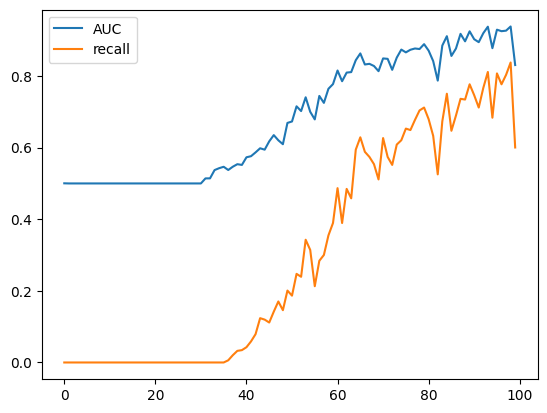

In [78]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show();
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['recall'], label='recall')
plt.legend()

165/165 [==============================] - 1s 5ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

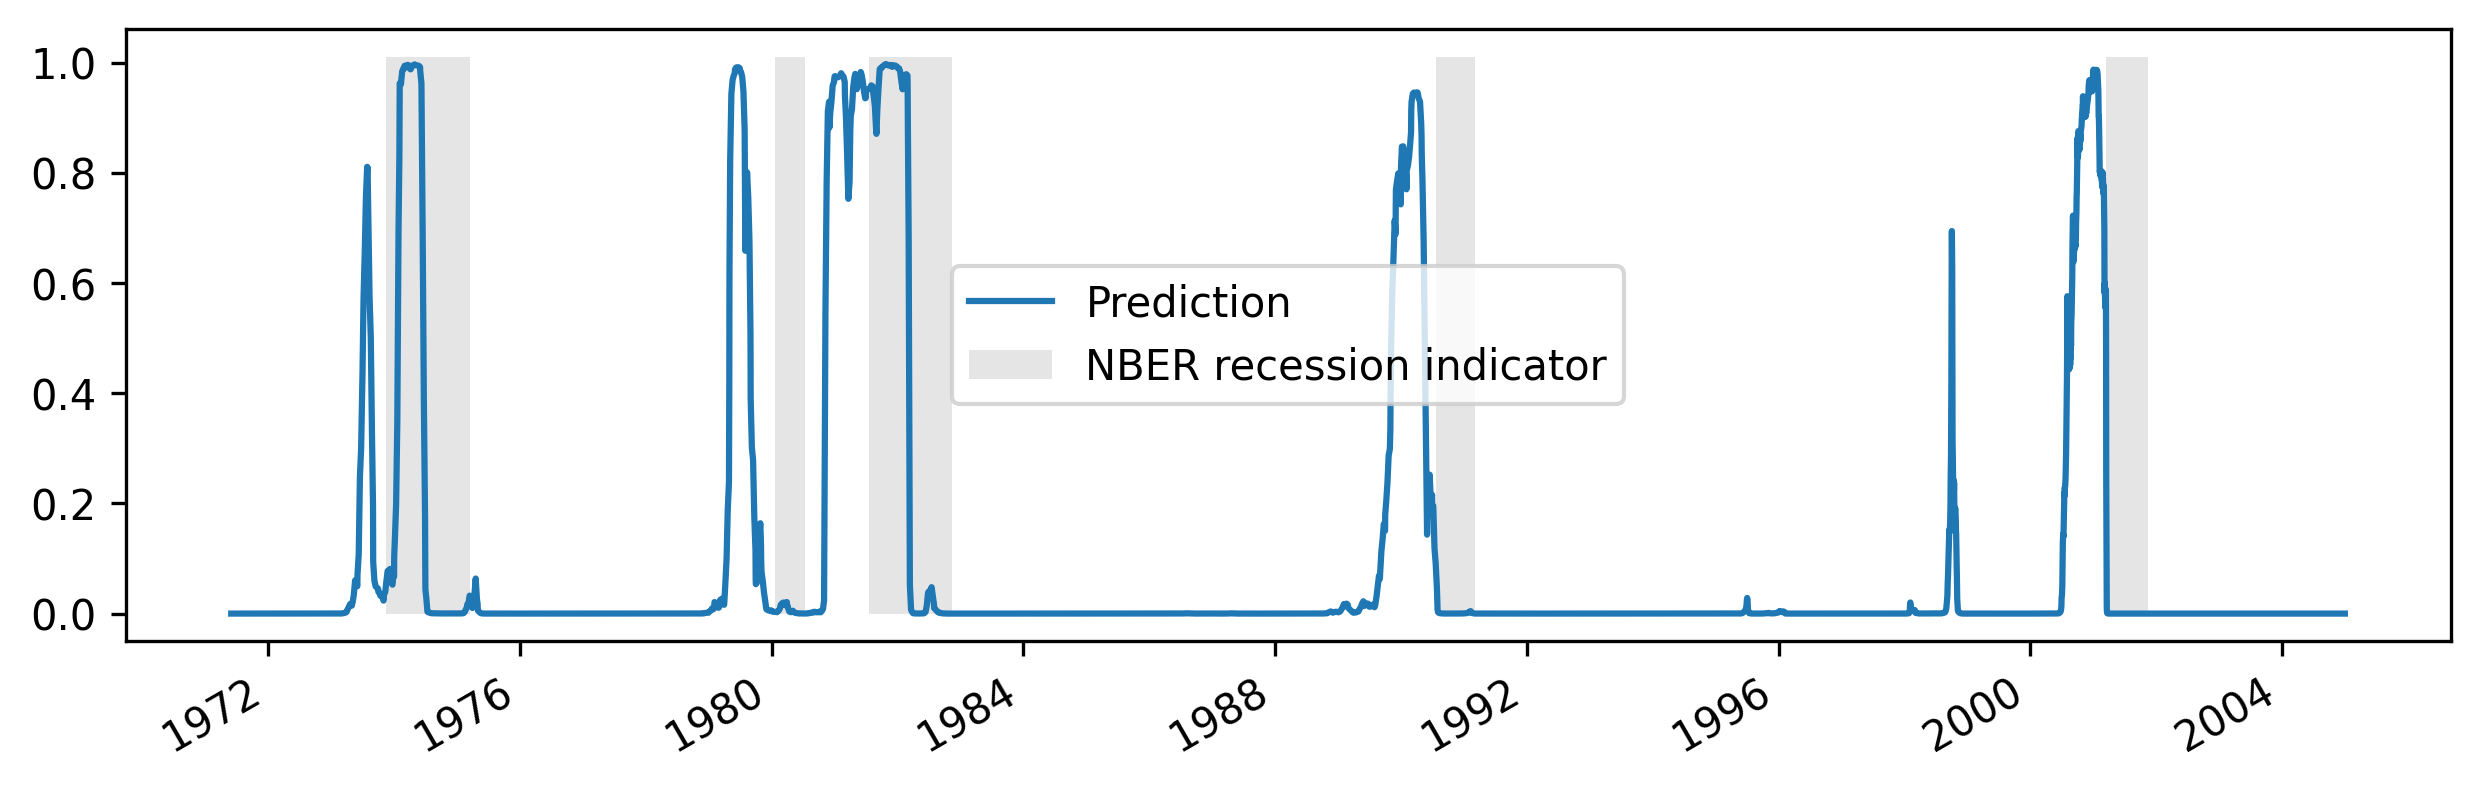

In [80]:
prediction_train=model.predict(trainX)
trainResults= pd.DataFrame()
trainResults['Actual']=df_for_training.iloc[-prediction_train.shape[0]:,-2]
trainResults['Pred']=prediction_train
plot(tf.math.sigmoid(prediction_train),df_for_training.iloc[-prediction_train.shape[0]:,-2])

190/190 [==============================] - 1s 6ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

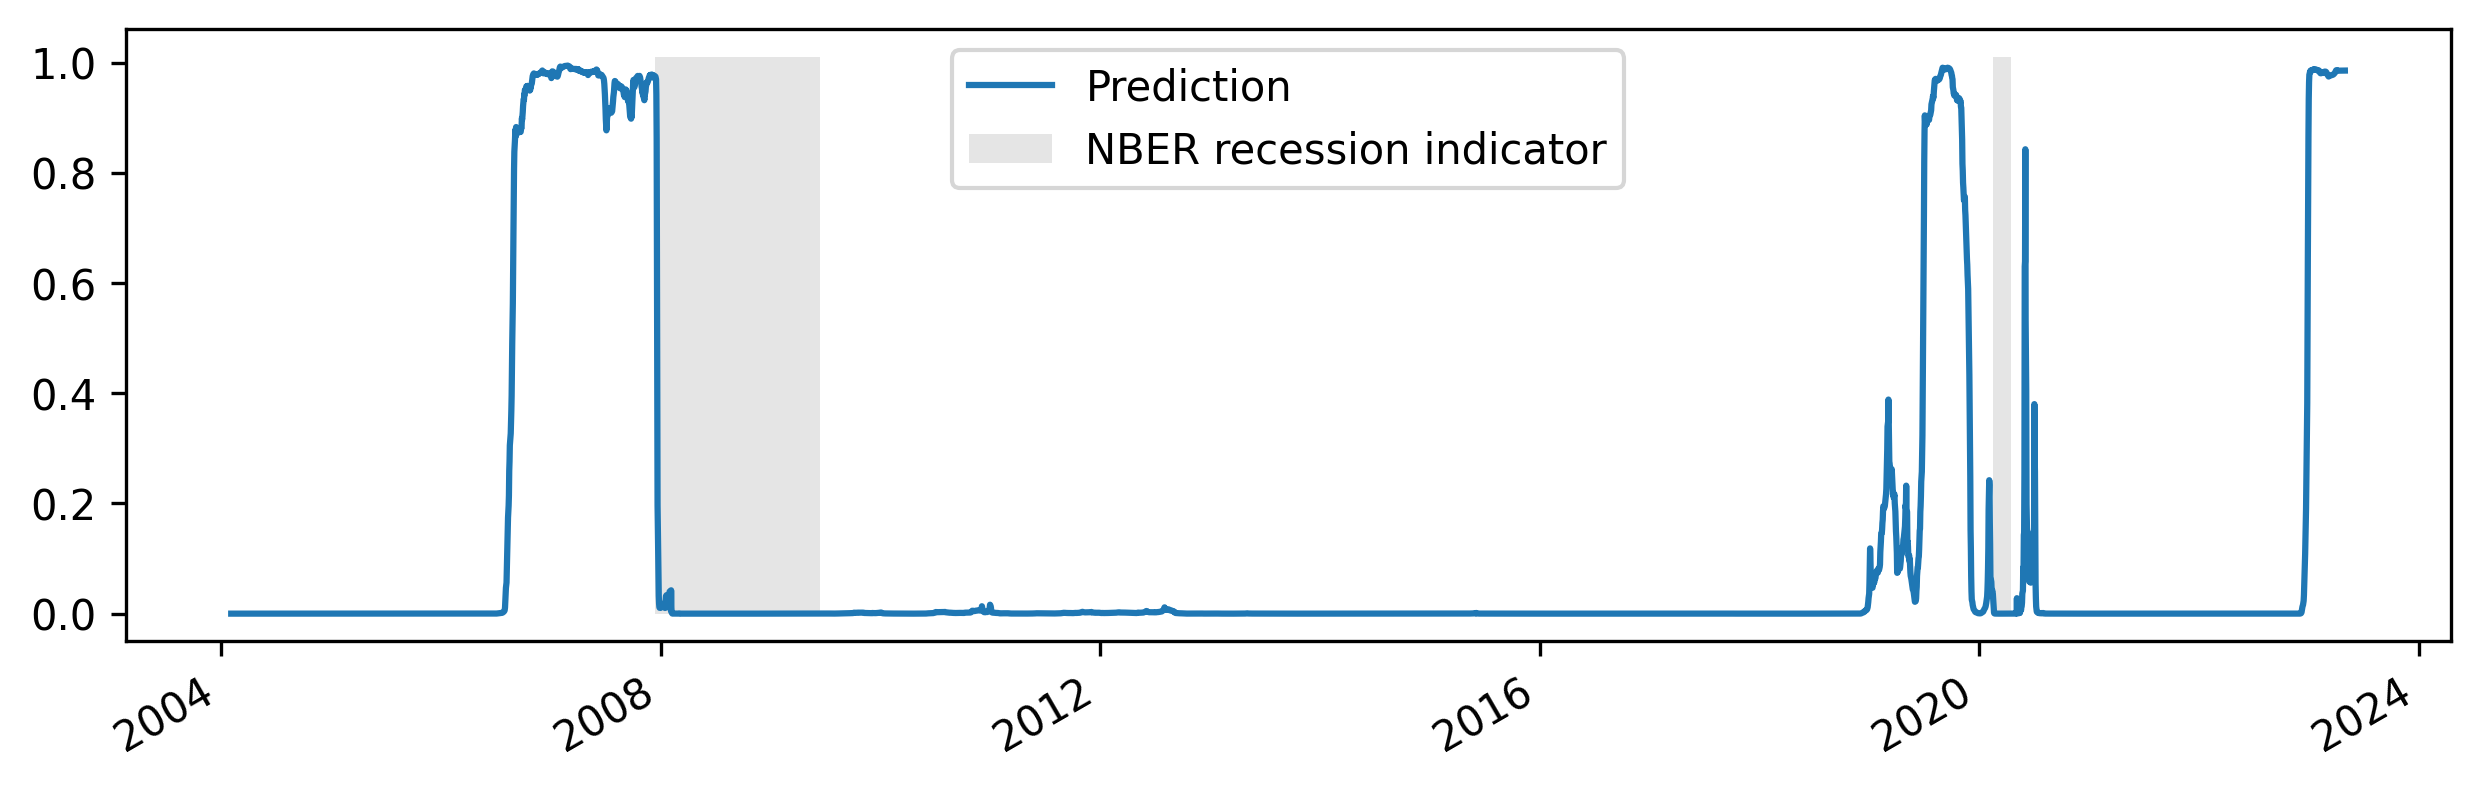

In [81]:
prediction=model.predict(testX)
testResults = pd.DataFrame()
testResults['Actual']=df_for_testing.iloc[-prediction.shape[0]:,-2]
testResults["Pred"]=prediction
# testResults=testResults.resample('M').max()
plot(tf.math.sigmoid(testResults['Pred']),testResults["Actual"])